Model MNIST from Scratch

In [5]:
import gzip
import os, os.path
import sys
import time
import urllib
import random

import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Dimensions of images in pixels.
#
IMAGEW = 28
IMAGEH = 28

LABELS = 10

URLBASE = 'http://yann.lecun.com/exdb/mnist/'
#
# Where we are going to stash the data.
#
DATADIR = "/Users/Simran/Desktop"

Retrieve Data

In [7]:
def cached_download(filename):
    """
    Only download data files if necessary.
    """
    try:
        os.stat(DATADIR)
    except:
        os.mkdir(DATADIR)
    #
    filepath = os.path.join(DATADIR, filename)
    #
    if not os.path.isfile(filepath):
        filepath, headers = urllib.request.urlretrieve(URLBASE + filename, filepath)
    #
    return filepath

In [8]:
images_pathname = cached_download('train-images-idx3-ubyte.gz')
labels_pathname = cached_download('train-labels-idx1-ubyte.gz')

Now we can unpack the zipped files and import the data.

In [9]:
def unpack_files(imagefile, labelsfile, count):
    with gzip.open(imagefile) as f:
        f.read(16)
        buf = f.read(IMAGEW * IMAGEH * count)
        images = np.frombuffer(buf, dtype = np.uint8).astype(np.float32)
        images = images.reshape(count, IMAGEW, IMAGEH)

    with gzip.open(labelsfile) as f:
        f.read(8)
        labels = np.frombuffer(f.read(1 * count), dtype = np.uint8).astype(np.int64)
    
    return (images, labels)

In [10]:
images, labels = unpack_files(images_pathname, labels_pathname, 60000)

Check the dimensions of the image and label data.

In [11]:
images.shape

(60000, 28, 28)

In [12]:
labels.shape

(60000,)

Visualise Images

In [13]:
imgmatrix = np.vstack([np.hstack([images[random.randrange(len(labels)),:,:] for i in range(10)]) for j in range(10)])

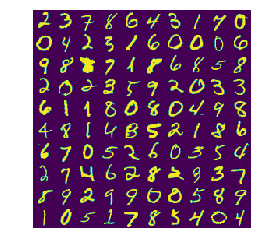

In [14]:
plt.imshow(imgmatrix, interpolation = 'nearest')
plt.axis('off')
plt.show()

Model

In [15]:
def soft_max(scores):
    exp_scores = np.exp(scores)
    return exp_scores / np.sum(exp_scores, axis = 1, keepdims = True)

def predict(model, x):
    """
    Generate a prediction via forward propagation.
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    
    return soft_max(z2)

def predict_class(model, x):
    return np.argmax(predict(model, x), axis = 1)

In [16]:
def loss(model, x, y):
    """
    Evaluate cross-entropy loss.
    """
    W1, W2 = model['W1'], model['W2']
    N = len(y)
    #
    probs = predict(model, x)
    #
    L = np.sum(-np.log(probs[range(N), y]))
    L += LAMBDA / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    #
    return L / N

In [17]:
def build_model(hdim, nbatch, passes = 20000, verbose = False, model = None):
    """
    Train model using backward propagation and mini-batch gradient descent.
    
    :param hdim: Number of hidden nodes.
    :param nbatch: Number of records per mini-batch.
    :param passes: Number of iterations.
    :param verbose: Whether or not to produce status information.
    :param model: An existing model (continue training).
    :return: data frame.
    """
    if model:
        W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    else:
        np.random.seed(0)
        W1 = np.random.randn(idim, hdim) / np.sqrt(idim)
        b1 = np.zeros((1, hdim))
        W2 = np.random.randn(hdim, odim) / np.sqrt(hdim)
        b2 = np.zeros((1, odim))
    
    for i in range(0, passes):
        index = random.sample(range(len(labels)), nbatch)

        X = images[index,]
        y = labels[index]

        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        #
        delta3 = soft_max(z2)

        delta3[range(nbatch), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis = 0, keepdims = True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        W1 += -epsilon * (dW1 + LAMBDA * W1)
        b1 += -epsilon * db1
        W2 += -epsilon * (dW2 + LAMBDA * W2)
        b2 += -epsilon * db2
        
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        if verbose and i % 1000 == 0:
          print("iteration %8i: Loss = %f" %(i, loss(model, X, y)))
    
    return model

Set up the model parameters.

In [18]:
idim = IMAGEW * IMAGEH
odim = LABELS

# Around 25 hidden nodes seems to work well, but start smaller for testing.

hdim = 25

# Size of mini-batch.

NBATCH = 50

First we need to flatten the image data. There will be as many input nodes in the network as there are pixels in the images.

In [19]:
images = images.reshape(len(labels), -1)
images.shape

(60000, 784)

Build a model.

In [20]:
# Learning rate.
#
epsilon = 0.00001

# Regularisation.
#
LAMBDA = 0.05

model = build_model(hdim, NBATCH, verbose = True)

iteration        0: Loss = 2.449418
iteration     1000: Loss = 1.307147
iteration     2000: Loss = 1.012318
iteration     3000: Loss = 0.861595
iteration     4000: Loss = 0.890830
iteration     5000: Loss = 0.697677
iteration     6000: Loss = 0.772092
iteration     7000: Loss = 0.781325
iteration     8000: Loss = 0.634915
iteration     9000: Loss = 0.590565
iteration    10000: Loss = 0.545782
iteration    11000: Loss = 0.519435
iteration    12000: Loss = 0.512705
iteration    13000: Loss = 0.568158
iteration    14000: Loss = 0.437703
iteration    15000: Loss = 0.561345
iteration    16000: Loss = 0.635570
iteration    17000: Loss = 0.510197
iteration    18000: Loss = 0.402747
iteration    19000: Loss = 0.502726


Do more iterations on the same model.

In [21]:
epsilon = 0.00001
LAMBDA = 0.02

model = build_model(hdim, NBATCH, verbose = True, model = model)

iteration        0: Loss = 0.340259
iteration     1000: Loss = 0.479854
iteration     2000: Loss = 0.524113
iteration     3000: Loss = 0.371035
iteration     4000: Loss = 0.232683
iteration     5000: Loss = 0.213377
iteration     6000: Loss = 0.534719
iteration     7000: Loss = 0.239831
iteration     8000: Loss = 0.474345
iteration     9000: Loss = 0.229020
iteration    10000: Loss = 0.414068
iteration    11000: Loss = 0.265092
iteration    12000: Loss = 0.313864
iteration    13000: Loss = 0.300335
iteration    14000: Loss = 0.224705
iteration    15000: Loss = 0.248250
iteration    16000: Loss = 0.474141
iteration    17000: Loss = 0.397390
iteration    18000: Loss = 0.336293
iteration    19000: Loss = 0.426000


Generate predictions from the training data.

In [22]:
labels_predict = predict_class(model, images)

Calculate the training accuracy across the whole data set.

In [24]:
sum(labels_predict == labels) / len(labels)

0.90780000000000005

Get the testing data.

In [25]:
test_images_pathname = cached_download('t10k-images-idx3-ubyte.gz')
test_labels_pathname = cached_download('t10k-labels-idx1-ubyte.gz')

In [26]:
test_images, test_labels = unpack_files(test_images_pathname, test_labels_pathname, 10000)

Flatten the test images.

In [27]:
test_images = test_images.reshape(len(test_labels), -1)

Generate predictions for the test images.

In [28]:
test_labels_predict = predict_class(model, test_images)

Calculate the test accuracy.

In [29]:
sum(test_labels_predict == test_labels) / len(test_labels)

0.90549999999999997